# Interactions - Lab

## Introduction

In this lab, you'll explore interactions in the Ames Housing dataset.

## Objectives

You will be able to:
- Implement interaction terms in Python using the `sklearn` and `statsmodels` packages 
- Interpret interaction variables in the context of a real-world problem 

## Build a baseline model 

You'll use a couple of built-in functions, which we imported for you below: 

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

If you still want to build a model in the end, you can do that, but this lab will just focus on finding meaningful insights in interactions and how they can improve $R^2$ values.

In [2]:
regression = LinearRegression()

Create a baseline model which includes all the variables we selected from the Ames housing data set to predict the house prices. Then use 10-fold cross-validation and report the mean $R^2$ value as the baseline $R^2$.

In [3]:
ames = pd.read_csv('ames.csv')
continuous = ['LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']
categoricals = ['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street', 'Neighborhood']
ames_cont = ames[continuous]
ames_cat = ames[categoricals]

In [4]:
log_names = [f'{column}_log' for column in ames_cont.columns]
for col in ames_cont.columns:
    ames_cont[col] = np.log(ames_cont[col])
ames_cont.columns = log_names

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
for col in ames_cont.columns:
    ames_cont[col] = (ames_cont[col]-ames_cont[col].mean()) / ames_cont[col].std()

ames_cat = pd.get_dummies(ames_cat)

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
ames_prep = pd.concat([ames_cont, ames_cat], axis=1)
X = ames_prep.drop('SalePrice_log', axis=1)
y = ames_prep['SalePrice_log']

In [7]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
cross_vals = cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation)
baseline = np.mean(cross_vals)
baseline

0.8174460502095708

## See how interactions improve your baseline

Next, create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the $R^2$. We'll look at the 3 interactions which have the biggest effect on our $R^2$, so print out the top 3 combinations.

You will create a `for` loop to loop through all the combinations of 2 predictors. You can use `combinations` from itertools to create a list of all the pairwise combinations. To find more info on how this is done, have a look [here](https://docs.python.org/2/library/itertools.html).

Since there are so many different neighbourhoods we will exclude

In [8]:
from itertools import combinations

In [9]:
combos = list(combinations(X.columns, 2))
r2s = []
X_try = X.copy()
for combo in combos:
    X_try['interact'] = X_try[combo[0]]*X_try[combo[1]]
    r2s.append(np.mean(cross_val_score(regression, X_try, y, scoring='r2', cv=crossvalidation)))

In [10]:
results = pd.DataFrame([combos, r2s]).transpose()
results.columns = ['combo', 'score']
results.sort_values(by='score', ascending=False).head(10)

,combo,score
411,"(KitchenQual_Ex, Neighborhood_ClearCr)",0.820341
271,"(BldgType_Duplex, Street_Pave)",0.819656
270,"(BldgType_Duplex, Street_Grvl)",0.819649
105,"(GrLivArea_log, BldgType_Duplex)",0.819634
111,"(GrLivArea_log, KitchenQual_TA)",0.819577
38,"(LotArea_log, Neighborhood_Mitchel)",0.819575
30,"(LotArea_log, Neighborhood_BrkSide)",0.819513
279,"(BldgType_Duplex, Neighborhood_Edwards)",0.819293
110,"(GrLivArea_log, KitchenQual_Gd)",0.81929
43,"(LotArea_log, Neighborhood_NridgHt)",0.819208


It looks like the top interactions involve the Neighborhood_Edwards feature so lets add the interaction between LotArea and Edwards to our model.

We can interpret this feature as the relationship between LotArea and SalePrice when the house is in Edwards or not.

## Visualize the Interaction

Separate all houses that are located in Edwards and those that are not. Run a linear regression on each population against `SalePrice`. Visualize the regression line and data points with price on the y axis and LotArea on the x axis.

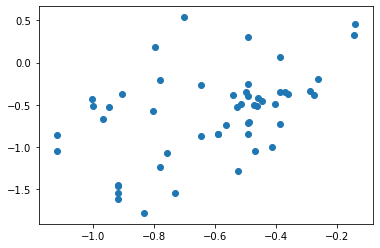

In [11]:
yduplex = ames_prep.loc[ames_prep['BldgType_Duplex']==1, ['GrLivArea_log', 'SalePrice_log']]
nduplex = ames_prep.loc[ames_prep['BldgType_Duplex']==0, ['GrLivArea_log', 'SalePrice_log']]

regression = LinearRegression()
regression.fit(yduplex['GrLivArea_log'].values.reshape(-1,1), yduplex['SalePrice_log'])
plt.scatter([x*regression.coef_+regression.intercept_ for x in yduplex['GrLivArea_log']], yduplex['SalePrice_log'])

## Build a final model with interactions

Use 10-fold cross-validation to build a model using the above interaction. 

In [16]:
regression = LinearRegression()
ames_prep['duplex_lotarea'] = ames_prep['BldgType_Duplex'] * ames_prep['LotArea_log']
test = np.mean(cross_val_score(regression, ames_prep.drop('SalePrice_log', axis=1), ames_prep['SalePrice_log'], scoring='r2', cv=crossvalidation))
test

0.8166763429743822

Our $R^2$ has increased considerably! Let's have a look in `statsmodels` to see if this interactions are significant.

In [18]:
import statsmodels.api as sm

df = sm.add_constant(ames_prep.drop('SalePrice_log', axis=1))
results = sm.OLS(ames_prep['SalePrice_log'], df).fit()

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     153.5
Date:                Wed, 29 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:12:34   Log-Likelihood:                -736.62
No. Observations:                1460   AIC:                             1571.
Df Residuals:                    1411   BIC:                             1830.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0597      0.048     -1.254      0.210      -0.153       0.034
LotArea_log              0.1069      0.019      5.635      0.000       0.070       0.144
1stFlrSF_log             0.1367      0.016      8.562      0.000       0.105       0.168
GrLivArea_log            0.3779      0.016     24.180      0.000       0.347       0.409
BldgType_1Fam            0.1392      0.034      4.070      0.000       0.072       0.206
BldgType_2fmCon         -0.0326      0.072     -0.455      0.650      -0.173       0.108
BldgType_Duplex         -0.2686      0.056     -4.760      0.000      -0.379      -0.158
BldgType_Twnhs           0.0073      0.074      0.100      0.921      -0.137       0.152
BldgType_TwnhsE          0.0950      0.048      1.996      0.046       0.002       0.188
KitchenQual_Ex           0.4974      0.045     11.110      0.000       0.410       0.585
KitchenQual_Fa          -0.5024      0.057     -8.798      0.000      -0.614      -0.390
KitchenQual_Gd           0.1168      0.028      4.205      0.000       0.062       0.171
KitchenQual_TA          -0.1714      0.027     -6.386      0.000      -0.224      -0.119
SaleType_COD            -0.1986      0.080     -2.471      0.014      -0.356      -0.041
SaleType_CWD             0.0287      0.191      0.150      0.881      -0.346       0.403
SaleType_Con             0.3839      0.269      1.426      0.154      -0.144       0.912
SaleType_ConLD           0.1147      0.138      0.834      0.405      -0.155       0.385
SaleType_ConLI          -0.1702      0.173     -0.986      0.324      -0.509       0.169
SaleType_ConLw          -0.1836      0.173     -1.060      0.290      -0.524       0.156
SaleType_New             0.0998      0.068      1.468      0.142      -0.034       0.233
SaleType_Oth            -0.1092      0.219     -0.500      0.617      -0.538       0.320
SaleType_WD             -0.0250      0.057     -0.437      0.662      -0.137       0.087
MSZoning_C (all)        -0.8191      0.130     -6.296      0.000      -1.074      -0.564
MSZoning_FV              0.2509      0.096      2.614      0.009       0.063       0.439
MSZoning_RH              0.0451      0.098      0.459      0.647      -0.148       0.238
MSZoning_RL              0.1795      0.049      3.694      0.000       0.084       0.275
MSZoning_RM              0.2839      0.054      5.230      0.000       0.177       0.390
Street_Grvl              0.0794      0.109      0.732      0.465      -0.134       0.292
Street_Pave             -0.1391      0.075     -1.861      0.063      -0.286       0.008
Neighborhood_Blmngtn     0.2333      0.111      2.100      0.036       0.015       0.451
Neighborhood_Blueste     0.2912      0.286      1.017      0.309      -0.270       0.853
Neighborhood_BrDale     -0.2247      0.122     -1.841    

What is your conclusion here?

In [14]:
# formulate your conclusion

## Summary

You should now understand how to include interaction effects in your model! As you can see, interactions can have a strong impact on linear regression models, and they should always be considered when you are constructing your models.